 # Libraries and Network Setup

In [ ]:
# Install the necessary libraries as mentioned in file requrirements.txt
!python3 -m venv .venv
!python3 -m pip install --upgrade pip
!pip install -r requirements.txt

  Using cached wntr-1.3.2-cp39-cp39-macosx_14_0_arm64.whl (2.4 MB)
  Using cached deap-1.4.2.tar.gz (1.1 MB)
  Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
  Using cached numpy-2.0.2-cp39-cp39-macosx_14_0_arm64.whl (5.3 MB)
  Using cached matplotlib-3.9.4-cp39-cp39-macosx_11_0_arm64.whl (7.8 MB)
  Using cached pandas-2.2.3-cp39-cp39-macosx_11_0_arm64.whl (11.3 MB)
  Using cached numpy-1.26.4-cp39-cp39-macosx_11_0_arm64.whl (14.0 MB)
  Using cached networkx-3.2.1-py3-none-any.whl (1.6 MB)
  Using cached scipy-1.13.1-cp39-cp39-macosx_12_0_arm64.whl (30.3 MB)
  Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl (111 kB)
  Using cached pillow-11.2.1-cp39-cp39-macosx_11_0_arm64.whl (3.0 MB)
  Using cached contourpy-1.3.0-cp39-cp39-macosx_11_0_arm64.whl (249 kB)
  Using cached importlib_resources-6.5.2-py3-none-any.whl (37 kB)
  Using cached fonttools-4.57.0-cp39-cp39-macosx_10_9_universal2.whl (2.8 MB)
  Using cached packaging-24.2-py

# Loading the Network

In [2]:
import wntr

Matplotlib is building the font cache; this may take a moment.


In [3]:
# Change the file address to work on a different network
wn = wntr.network.WaterNetworkModel("Network Files/Net3.inp")

## Details of the Network

In [4]:
wn.describe(level=2)

{'Nodes': {'Junctions': 92, 'Tanks': 3, 'Reservoirs': 2},
 'Links': {'Pipes': 117,
  'Pumps': {'Head': 2, 'Power': 0},
  'Valves': {'PRV': 0, 'PSV': 0, 'PBV': 0, 'TCV': 0, 'FCV': 0, 'GPV': 0}},
 'Patterns': 5,
 'Curves': {'Pump': 2, 'Efficiency': 0, 'Headloss': 0, 'Volume': 0},
 'Sources': 0,
 'Controls': 6}

In [5]:
[name for name in dir(wn) if not name.startswith('_')]

['add_control',
 'add_curve',
 'add_junction',
 'add_msx_model',
 'add_pattern',
 'add_pipe',
 'add_pump',
 'add_reservoir',
 'add_source',
 'add_tank',
 'add_valve',
 'assign_demand',
 'control_name_list',
 'controls',
 'convert_controls_to_rules',
 'curve_name_list',
 'curves',
 'describe',
 'fcv_name_list',
 'fcvs',
 'from_dict',
 'from_gis',
 'get_control',
 'get_curve',
 'get_graph',
 'get_link',
 'get_links_for_node',
 'get_node',
 'get_pattern',
 'get_source',
 'gpv_name_list',
 'gpvs',
 'head_pump_name_list',
 'head_pumps',
 'junction_name_list',
 'junctions',
 'link_name_list',
 'links',
 'msx',
 'name',
 'node_name_list',
 'nodes',
 'num_controls',
 'num_curves',
 'num_junctions',
 'num_links',
 'num_nodes',
 'num_patterns',
 'num_pipes',
 'num_pumps',
 'num_reservoirs',
 'num_sources',
 'num_tanks',
 'num_valves',
 'options',
 'pattern_name_list',
 'patterns',
 'pbv_name_list',
 'pbvs',
 'pipe_name_list',
 'pipes',
 'power_pump_name_list',
 'power_pumps',
 'prv_name_list',
 

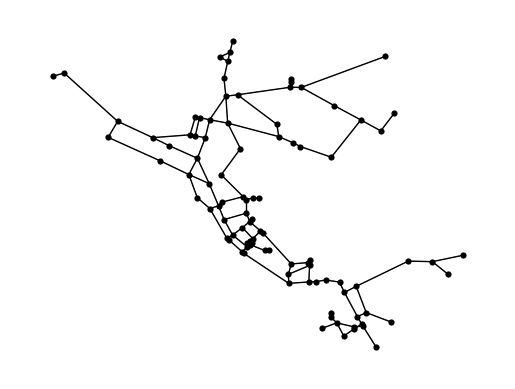

In [6]:
ax = wntr.graphics.plot_network(wn)

# Genetic Algorithm

## Setting up Manual Functions

### Repair Function Setup

In [7]:
def repair():
    pass

### Objective Function Setup

In [8]:
def evaluation():
    pass

## Setting up DEAP framework

### Setting up Libraries

In [9]:
# Necessary Libraries for DEAP and Torch
from deap import base, tools, creator, algorithms

In [ ]:
import random

# --- CONFIGURATION ---
CHROM_SIZE = wn.describe(level=1)['Links']['Pumps'] * (int(wn.options.time.duration / wn.options.time.hydraulic_timestep) + 1) # No of Pumps * No of Timestamps

# --- CREATE TYPES ---

# Assigning Mult-Class Fitness Weigths
creator.create("FitnessMulti", base.Fitness, weights=(-1.0,-1.0,-1.0))

# Defining Individual
creator.create("Individual", list, fitness = creator.FitnessMulti)

toolbox = base.Toolbox()

# --- CREATE TOOLS ---

# Define Binary Genes
toolbox.register("attr_bool", random.randint, 0, 1)

# Define Individual (List of Binary Values)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=CHROM_SIZE)

# Define Random Population
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Register the Fitness function
toolbox.register("evaluate", evaluation)

# Define Selection Methodology
toolbox.register("select", tools.selNSGA3)

# Define Crossover Methodology
toolbox.register("mate", tools.cxTwoPoints)

# Define Mutation Methodology
toolbox.register("mutate", tools.mutFlipBit, indpb = 0.1)

# Set Hall of Fame
hof = tools.HallOfFame(10)

# --- GENETIC ALGO ---

def run_ga(pop_size = 40, generations = 5, cx_prob = 0.7, mut_prob = 0.4):
    
    population = toolbox.population(n = pop_size)

    # Multi-Objective Statistics
    stats = tools.Statistics(lambda ind: ind.fitness.values)

    # Run the Genetic Algorithm
    population, logbook = algorithms.eaMuPlusLambda(population=population,
                                                    toolbox=toolbox,
                                                    mu = round(pop_size * 0.7)
                                                    lambda_= round(pop_size * 0.5),
                                                    cxpb=cx_prob,
                                                    mutpb=mut_prob,
                                                    ngen=generations,
                                                    stats=stats,
                                                    halloffame=hof,
                                                    verbose=True,
                                                    )
    
    best_inds = hof
    print("Best Individual : ", best_inds)
    print("Fitness : ", best_inds.fitness.values)

    return best_inds, logbook, population, hof

best_sols, logbook, population, hof = run_ga()

# Network Simulation testing